### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/LOGS/LOG_2019-04-24_19_35_East_Melanesian_Islands/Abstract_Database_2019-04-24_19_35_ANALYTICAL"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 20, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)
    
	#visualizer_generator(lda_model, corpus, id2word, abstracts_log_name, status_logger_name)
    
nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]10:18:39 Initiating the NLP Engine
[INFO]10:18:39 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/LOGS/LOG_2019-04-24_19_35_East_Melanesian_Islands/Abstract_Database_2019-04-24_19_35_ANALYTICAL.txt is being ported to dataframe
[INFO]10:18:39 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/LOGS/LOG_2019-04-24_19_35_East_Melanesian_Islands/Abstract_Database_2019-04-24_19_35_ANALYTICAL.txt has been ported to dataframe
[INFO]10:18:39 Trimming data and preparing list of words
[["'Variation in human skin pigmentation evolved in response to the selective pressure of ultra-violet radiation (UVR). Selection to maintain darker skin in high UVR environments is expected to constrain pigmentation phenotype and variation in pigmentation loci. Consistent with this hypothesis, the gene MC1R exhibits reduced diversity in African populations from high UVR regions compared to low-UVR non-African populations. However, MC1R diversity in non-African populations that have evolved under high-UVR conditi

[INFO]10:18:39 Generating bigrams
[INFO]10:18:39 Generating word bigrams
[INFO]10:18:40 Generated word bigrams
[INFO]10:18:40 Beginning lemmatization
[INFO]10:18:45 Ending lemmatization
[INFO]10:18:51 Issued perplexity: -13.381522955306107
[INFO]10:18:51 Idling the NLP Engine


In [13]:
lda_model

In [14]:
lda_model.print_topics()

[(0,
  '0.045*"basin" + 0.030*"rock" + 0.024*"zone" + 0.022*"type" + 0.022*"volcanic" + 0.021*"ridge" + 0.019*"subduction" + 0.017*"fragment" + 0.016*"drug" + 0.016*"crust"'),
 (1,
  '0.058*"water" + 0.026*"ocean" + 0.025*"hunter" + 0.024*"ratio" + 0.023*"source" + 0.021*"density" + 0.019*"pacific" + 0.015*"indian" + 0.014*"protein" + 0.014*"fat"'),
 (2,
  '0.023*"property" + 0.020*"tendency" + 0.010*"analytical" + 0.007*"reproduce" + 0.007*"promise" + 0.006*"articulation" + 0.004*"intellectual" + 0.004*"conceptual" + 0.003*"meeting" + 0.003*"production"'),
 (3,
  '0.024*"global" + 0.022*"historical" + 0.018*"pacific" + 0.016*"human" + 0.015*"economic" + 0.014*"climate_change" + 0.014*"perspective" + 0.014*"practice" + 0.013*"impact" + 0.013*"political"'),
 (4,
  '0.154*"htlv" + 0.056*"virus" + 0.048*"school" + 0.046*"infection" + 0.045*"positive" + 0.023*"conflict" + 0.019*"isolate" + 0.017*"type" + 0.015*"trial" + 0.010*"program"'),
 (5,
  '0.045*"earthquake" + 0.045*"seismic" + 0.03

In [15]:
mallet_path = '/home/sarthak/projects/Bias/scripts/mallet-2.0.8/bin/mallet'

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('important', 0.028878822197055492),
   ('present', 0.028312570781426953),
   ('sample', 0.027180067950169876),
   ('source', 0.02548131370328426),
   ('period', 0.02491506228765572),
   ('common', 0.02378255945639864),
   ('activity', 0.01868629671574179),
   ('part', 0.01698754246885617),
   ('discuss', 0.01698754246885617),
   ('determine', 0.015855039637599093)]),
 (5,
  [('island', 0.160042395336513),
   ('west', 0.021197668256491786),
   ('occur', 0.019077901430842606),
   ('derive', 0.018018018018018018),
   ('pacific', 0.016428192898781134),
   ('volcanic', 0.01483836777954425),
   ('polynesia', 0.014308426073131956),
   ('introduction', 0.012718600953895072),
   ('migration', 0.011658717541070483),
   ('remote', 0.011128775834658187)]),
 (8,
  [('community', 0.030756087142246903),
   ('forest', 0.02093122597180692),
   ('resource', 0.02050405809483127),
   ('food', 0.01794105083297736),
   ('impact', 0.016659547202050404),
   ('land', 0.016659547202050404),
   ('chang

In [18]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

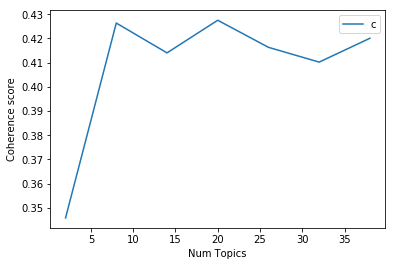

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.033*"basin" + 0.021*"zone" + 0.016*"spread" + 0.016*"volcanic" + '
  '0.016*"plate" + 0.014*"subduction" + 0.014*"ridge" + 0.014*"arc" + '
  '0.014*"continental" + 0.013*"tectonic"'),
 (1,
  '0.048*"human" + 0.023*"society" + 0.022*"culture" + 0.022*"cultural" + '
  '0.019*"review" + 0.018*"process" + 0.018*"make" + 0.017*"role" + '
  '0.013*"article" + 0.013*"approach"'),
 (2,
  '0.024*"source" + 0.024*"suggest" + 0.024*"range" + 0.022*"rock" + '
  '0.017*"deposit" + 0.016*"element" + 0.015*"gold" + 0.013*"xb" + '
  '0.012*"associate" + 0.011*"sample"'),
 (3,
  '0.029*"variation" + 0.029*"diversity" + 0.019*"represent" + 0.019*"genetic" '
  '+ 0.018*"genotype" + 0.017*"collection" + 0.015*"group" + 0.015*"type" + '
  '0.015*"origin" + 0.015*"vanuatu"'),
 (4,
  '0.028*"change" + 0.023*"resource" + 0.022*"community" + 0.021*"food" + '
  '0.020*"natural" + 0.019*"land" + 0.019*"village" + 0.018*"present" + '
  '0.017*"environmental" + 0.017*"year"'),
 (5,
  '0.060*"region" + 0.

In [23]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)

In [24]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [25]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.2981,"population, genetic, frequency, gene, allele, ...",['Variation in human skin pigmentation evolved...
1,1,5.0,0.2108,"region, group, show, major, australia, southea...","['The Cicadoidea fauna of Wallacea, New Guinea..."
2,2,2.0,0.2319,"source, suggest, range, rock, deposit, element...",['The anthropogenic plutonium isotopes are imp...
3,3,16.0,0.2513,"evidence, recent, history, archaeological, sit...",['The Malayo-Oceanic tropics have long been re...
4,4,11.0,0.6551,"pattern, current, xb, flow, large, result, dat...",['We conducted 1-year-long mooring observation...
5,5,11.0,0.5709,"pattern, current, xb, flow, large, result, dat...",['Laboratory and field investigations were car...
6,6,14.0,0.6231,"system, guinea, development, local, community,...",['It is the contention of this paper that some...
7,7,16.0,0.2511,"evidence, recent, history, archaeological, sit...","[The Pacific Islands or Oceania, typically sub..."
8,8,6.0,0.5925,"difference, prevalence, people, significant, p...",['The study of different ethnic groups living ...
9,9,0.0,0.5226,"basin, zone, spread, volcanic, plate, subducti...","['Swath bathymetric, sonar imagery and seismic..."


In [26]:
#df_dominant_topic.to_csv('Melanasian.csv')

In [27]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [28]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [29]:
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [30]:
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6209,"basin, zone, spread, volcanic, plate, subducti...",['The Manus Basin in the eastern Bismarck Sea ...
1,1.0,0.4133,"human, society, culture, cultural, review, pro...",['There exists an unfounded and unproven \xe2\...
2,2.0,0.5711,"source, suggest, range, rock, deposit, element...",['The Tallberg deposit is situated in the Skel...
3,3.0,0.5955,"variation, diversity, represent, genetic, geno...",[Amplified fragment length polymorphism marker...
4,4.0,0.4124,"change, resource, community, food, natural, la...",['Coupled human\xe2\x80\x93environmental timel...


In [31]:
#sent_topics_sorteddf_mallet.to_csv('Melanasian_Topics_Contribution.csv')

In [32]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,17.0,"population, genetic, frequency, gene, allele, ...",93.0,0.1732
1,5.0,"region, group, show, major, australia, southea...",41.0,0.0764
2,2.0,"source, suggest, range, rock, deposit, element...",25.0,0.0466
3,16.0,"evidence, recent, history, archaeological, sit...",24.0,0.0447
4,11.0,"pattern, current, xb, flow, large, result, dat...",25.0,0.0466
5,11.0,"pattern, current, xb, flow, large, result, dat...",30.0,0.0559
6,14.0,"system, guinea, development, local, community,...",22.0,0.0410
7,16.0,"evidence, recent, history, archaeological, sit...",14.0,0.0261
8,6.0,"difference, prevalence, people, significant, p...",30.0,0.0559
9,0.0,"basin, zone, spread, volcanic, plate, subducti...",10.0,0.0186


In [33]:
#df_dominant_topics.to_csv('Melanasiab_Topics.csv')

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [35]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     38.283867        1       1 -0.336583  0.102827
10     11.939971        1       2 -0.240248 -0.208540
17     10.655602        1       3 -0.219457  0.244159
3       6.984734        1       4 -0.145766 -0.168064
15      5.382728        1       5 -0.087828  0.009848
6       4.723896        1       6 -0.086548 -0.084331
0       4.064304        1       7  0.047454  0.077262
7       3.229234        1       8  0.076404  0.024520
18      2.665196        1       9  0.022975 -0.043635
1       2.398290        1      10  0.047362  0.024612
5       2.156486        1      11  0.072503  0.021713
12      1.457713        1      12  0.108492 -0.003079
4       1.451443        1      13  0.093845  0.025251
9       1.232584        1      14  0.092065  0.000229
11      1.196871        1      15  0.083374 -0.001167
19      1.175076        1      16  0.088104 -0.0017

In [36]:
#pyLDAvis.save_html(vis, 'Melanasian.html')

In [37]:
pyLDAvis.enable_notebook()

In [38]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     38.283867        1       1 -0.336583  0.102827
10     11.939971        1       2 -0.240248 -0.208540
17     10.655602        1       3 -0.219457  0.244159
3       6.984734        1       4 -0.145766 -0.168064
15      5.382728        1       5 -0.087828  0.009848
6       4.723896        1       6 -0.086548 -0.084331
0       4.064304        1       7  0.047454  0.077262
7       3.229234        1       8  0.076404  0.024520
18      2.665196        1       9  0.022975 -0.043635
1       2.398290        1      10  0.047362  0.024612
5       2.156486        1      11  0.072503  0.021713
12      1.457713        1      12  0.108492 -0.003079
4       1.451443        1      13  0.093845  0.025251
9       1.232584        1      14  0.092065  0.000229
11      1.196871        1      15  0.083374 -0.001167
19      1.175076        1      16  0.088104 -0.001708
13      0.465431        1      17  0.100627 -0.008010
2       0.236458        1      18  0.096569 -0.003648
14      0.219413        1      19  0.094534 -0.003990
8       0.080721        1      20  0.092120 -0.004251, topic_info=     Category      Freq             Term       Total  loglift  logprob
3818  Default  341.0000               xa  341.000000  30.0000  30.0000
6174  Default  527.0000       population  527.000000  29.0000  29.0000
6775  Default  279.0000               xc  279.000000  28.0000  28.0000
3292  Default   95.0000             htlv   95.000000  27.0000  27.0000
7202  Default  206.0000          genetic  206.000000  26.0000  26.0000
256   Default  177.0000             type  177.000000  25.0000  25.0000
1390  Default  228.0000            group  228.000000  24.0000  24.0000
3780  Default   89.0000               xb   89.000000  23.0000  23.0000
445   Default   66.0000           factor   66.000000  22.0000  22.0000
3641  Default   78.0000            basin   78.000000  21.0000  21.0000
299   Default   92.0000           source   92.000000  20.0000  20.0000
6303  Default  118.0000             gene  118.000000  19.0000  19.0000
6948  Default  138.0000           system  138.000000  18.0000  18.0000
2096  Default  123.0000           global  123.000000  17.0000  17.0000
3773  Default   59.0000            water   59.000000  16.0000  16.0000
2322  Default  108.0000            trade  108.000000  15.0000  15.0000
4310  Default  135.0000           social  135.000000  14.0000  14.0000
734   Default  128.0000        community  128.000000  13.0000  13.0000
1517  Default  106.0000        frequency  106.000000  12.0000  12.0000
5801  Default  172.0000            level  172.000000  11.0000  11.0000
2945  Default   87.0000             zone   87.000000  10.0000  10.0000
6223  Default  158.0000          pacific  158.000000   9.0000   9.0000
5645  Default   71.0000          current   71.000000   8.0000   8.0000
556   Default   87.0000       difference   87.000000   7.0000   7.0000
3501  Default   77.0000          article   77.000000   6.0000   6.0000
7011  Default   82.0000              age   82.000000   5.0000   5.0000
3234  Default   39.0000       prevalence   39.000000   4.0000   4.0000
4377  Default  177.0000              new  177.000000   3.0000   3.0000
5517  Default  233.0000           result  233.000000   2.0000   2.0000
2491  Default   60.0000            ocean   60.000000   1.0000   1.0000
...       ...       ...              ...         ...      ...      ...
3701  Topic20    0.0046         headwall    0.918011   1.8257  -8.9121
1233  Topic20    0.0046        outermost    0.918013   1.8257  -8.9121
3703  Topic20    0.0046              mlo    0.918011   1.8257  -8.9121
1232  Topic20    0.0046         directly    0.918031   1.8256  -8.9121
2463  Topic20    0.0046         nearctic    0.918015   1.8257  -8.9121
2465  Topic20    0.0046               ga    0.918014   1.8257  -8.9121
2466  Topic20    0.0046          achieve   14.182184  -0.9119  -8.9121
